In [1]:
import json
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats

import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.font_manager

import warnings
warnings.filterwarnings('ignore')

<font size="5">Two ways to detect outliers: </font>

**Viewer-based:**  
 * table schema: uniqueId, total plays, total play hours, unique assets<br>

**Content-based:**  
 * table schema: assetGuid, total plays, total play hours, unique viewer

**Device-based method**, need TBD

<font size="5">Outlier detection Algorithms:</font>

**1. Unsupervised Outlier Detection:**

* Training data (unlabelled) contains both normal and anomalous observations.
* The model identifies outliers during the fitting process.
* This approach is taken when outliers are defined as points that exist in low-density regions in the data.
* Any new observations that do not belong to high-density regions are considered outliers.

**2. Semi-supervised Novelty Detection:**
* Training data consists only of observations describing normal behavior.
* The model is fit on training data and then used to evaluate new observations.
* This approach is taken when outliers are defined as points differing from the distribution of the training data.
* Any new observations differing from the training data within a threshold, even if they form a high-density region, are considered outliers.

**3. Supervised Outlier Classification:**
* The ground truth label (inlier vs outlier) for every observation is known.
* The model is fit on imbalanced training data and then used to classify new observations.
* This approach is taken when ground truth is available and it is assumed that outliers will follow the same distribution as in the training set.
* Any new observations are classified using the model.

# This is a example of unsupervised, viewer-based outlier detection

In [2]:
df = pd.read_json("data/ds_sling_outlier_uniqueid", lines=True)
df.head()

,uniqueId,total_plays,total_playhrs,unique_assets
0,8b1c9e4e-5d32-11e9-bf56-12762db499aa,2284,15.313624,26
1,1d01c360-0978-11ea-9e7a-0e37a7ba65ed,1530,8.784932,10
2,ef2364f4-d9a6-11e9-822a-0eb34a1dd7fc,1366,10.782440,12
3,f0e909d8-f680-11e8-b915-120d217bbebc,1294,20.772564,71
4,e6a6e502-8418-11e7-b542-0e17a8ea5941,1254,6.972494,10


## Scatter Plot on total plays, total play hours and unique viewers

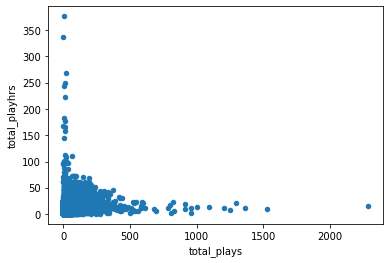

In [18]:
df.plot.scatter('total_plays', 'total_playhrs')

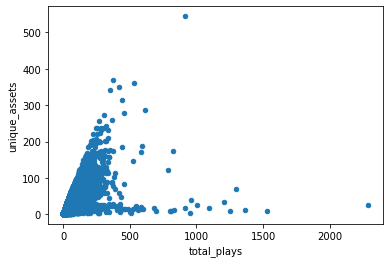

In [19]:
df.plot.scatter('total_plays', 'unique_assets')

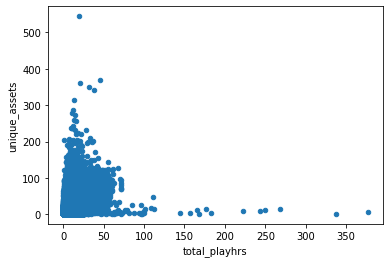

In [20]:
df.plot.scatter('total_playhrs', 'unique_assets')

## 10 different clustering algorithms 

* Angle-based Outlier Detector (ABOD)
* Cluster-based Local Outlier Factor (CBLOF)
* Histogram-base Outlier Detection (HBOS)
* Isolation Forest
* K Nearest Neighbors (KNN)
* Average KNN
* Local Outlier Factor (LOF)
* Minimum Covariance Determinant (MCD)
* One-class SVM (OCSVM)
* Principal Component Analysis (PCA)

In [3]:
# Import models
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.models.mcd import MCD
from pyod.models.ocsvm import OCSVM
from pyod.models.pca import PCA
from pyod.models.lscp import LSCP

from sklearn.preprocessing import MinMaxScaler

In [20]:
random_state = np.random.RandomState(42)
#outliers_fraction = 0.02
# Define seven outlier detection tools to be compared
classifiers = {
        'Angle-based Outlier Detector (ABOD)':
        ABOD(contamination=outliers_fraction),
    'Cluster-based Local Outlier Factor (CBLOF)':
        CBLOF(contamination=outliers_fraction,
              check_estimator=False, random_state=random_state),
    #'Feature Bagging':
    #    FeatureBagging(LOF(n_neighbors=35),
    #                   contamination=outliers_fraction,
    #                   random_state=random_state),
    'Histogram-base Outlier Detection (HBOS)': HBOS(
        contamination=outliers_fraction),
    'Isolation Forest': IForest(contamination=outliers_fraction,
                                random_state=random_state),
    'K Nearest Neighbors (KNN)': KNN(
        contamination=outliers_fraction),
    'Average KNN': KNN(method='mean',
                       contamination=outliers_fraction),
    'Local Outlier Factor (LOF)':
        LOF(n_neighbors=35, contamination=outliers_fraction),
    'Minimum Covariance Determinant (MCD)': MCD(
        contamination=outliers_fraction, random_state=random_state),
    'One-class SVM (OCSVM)': OCSVM(contamination=outliers_fraction),
    'Principal Component Analysis (PCA)': PCA(
        contamination=outliers_fraction, random_state=random_state)
}

In [21]:
def plot_outlier(df, f1, f2, fraction):
    outliers_fraction = fraction
    scaler = MinMaxScaler(feature_range=(0, 1))
    df[[f1, f2]] = scaler.fit_transform(df[[f1, f2]])
    X1 = df[f1].values.reshape(-1,1)
    X2 = df[f2].values.reshape(-1,1)

    X = np.concatenate((X1,X2),axis=1)
    
    xx , yy = np.meshgrid(np.linspace(0,1 , 200), np.linspace(0, 1, 200))

    for i, (clf_name, clf) in enumerate(classifiers.items()):
        clf.fit(X)
        # predict raw anomaly score
        scores_pred = clf.decision_function(X) * -1
            
        # prediction of a datapoint category outlier or inlier
        y_pred = clf.predict(X)
        n_inliers = len(y_pred) - np.count_nonzero(y_pred)
        n_outliers = np.count_nonzero(y_pred == 1)
        plt.figure(figsize=(10, 10))
        
        # copy of dataframe
        dfx = df
        dfx['outlier'] = y_pred.tolist()
        
        # IX1 - inlier feature 1,  IX2 - inlier feature 2
        IX1 =  np.array(dfx[f1][dfx['outlier'] == 0]).reshape(-1,1)
        IX2 =  np.array(dfx[f2][dfx['outlier'] == 0]).reshape(-1,1)
        
        # OX1 - outlier feature 1, OX2 - outlier feature 2
        OX1 =  dfx[f1][dfx['outlier'] == 1].values.reshape(-1,1)
        OX2 =  dfx[f2][dfx['outlier'] == 1].values.reshape(-1,1)
             
        print('OUTLIERS : ',n_outliers,'INLIERS : ',n_inliers, clf_name)
            
        # threshold value to consider a datapoint inlier or outlier
        threshold = stats.scoreatpercentile(scores_pred,100 * outliers_fraction)
            
        # decision function calculates the raw anomaly score for every point
        Z = clf.decision_function(np.c_[xx.ravel(), yy.ravel()]) * -1
        Z = Z.reshape(xx.shape)
              
        # fill blue map colormap from minimum anomaly score to threshold value
        plt.contourf(xx, yy, Z, levels=np.linspace(Z.min(), threshold, 7),cmap=plt.cm.Blues_r)
            
        # draw red contour line where anomaly score is equal to thresold
        a = plt.contour(xx, yy, Z, levels=[threshold],linewidths=2, colors='red')
            
        # fill orange contour lines where range of anomaly score is from threshold to maximum anomaly score
        plt.contourf(xx, yy, Z, levels=[threshold, Z.max()],colors='orange')
            
        b = plt.scatter(IX1,IX2, c='white',s=20, edgecolor='k')
        
        c = plt.scatter(OX1,OX2, c='black',s=20, edgecolor='k')
           
        plt.axis('tight')  
        
        # loc=2 is used for the top left corner 
        plt.legend(
            [a.collections[0], b,c],
            ['learned decision function', 'inliers','outliers'],
            prop=matplotlib.font_manager.FontProperties(size=20),
            loc=2)
          
        plt.xlim((0, 1))
        plt.ylim((0, 1))
        plt.title(clf_name)
        plt.show()

## Compare clustering algorithms on total_play_hours and unique_assets

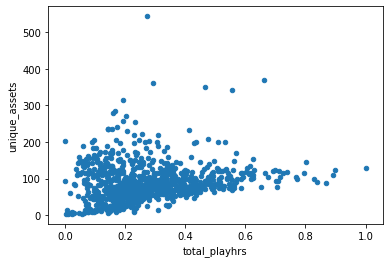

In [32]:
df[:1000].plot.scatter('total_playhrs', 'unique_assets')

In [37]:
df[:1000][df[:1000]['unique_assets']>300]

,uniqueId,total_plays,total_playhrs,unique_assets
11,b1c84662-ce91-11e9-8c3b-0a9aceab6130,911,0.273578,544
28,3c1e6f94-7e73-11ea-996a-0eabf3bd8043,531,0.291814,362
39,707fc7c6-107a-11e6-a61f-128e56ace683,444,0.193846,314
48,95c01eda-20dc-11e9-a38b-0a0406e6cb84,420,0.466884,350
56,463c140e-0f9d-11e9-9521-0aabc2477fa8,377,0.660928,370
64,444180c6-7fa3-11e6-8799-12e0e3a3ed5d,350,0.554791,343


OUTLIERS :  20 INLIERS :  980 Angle-based Outlier Detector (ABOD)


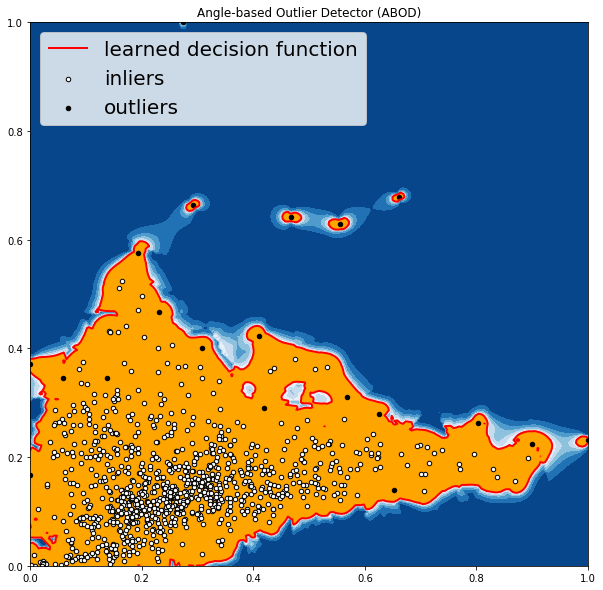

OUTLIERS :  20 INLIERS :  980 Cluster-based Local Outlier Factor (CBLOF)


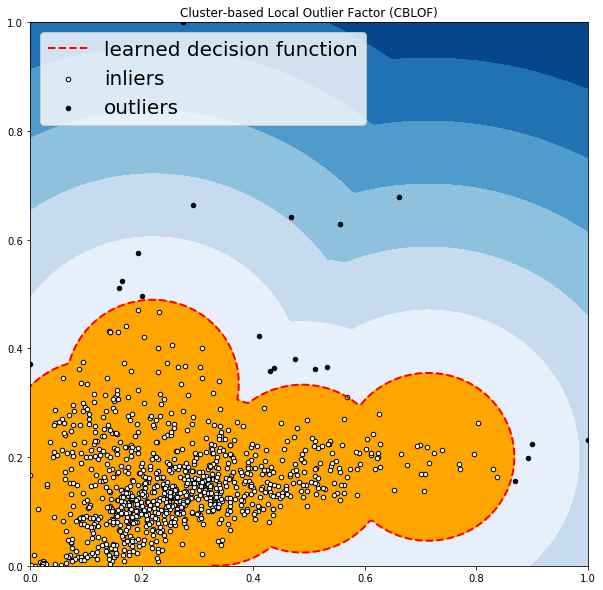

OUTLIERS :  19 INLIERS :  981 Histogram-base Outlier Detection (HBOS)


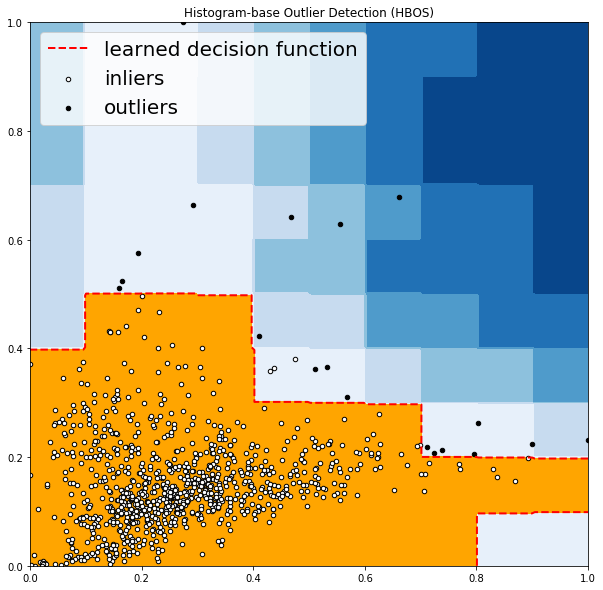

OUTLIERS :  20 INLIERS :  980 Isolation Forest


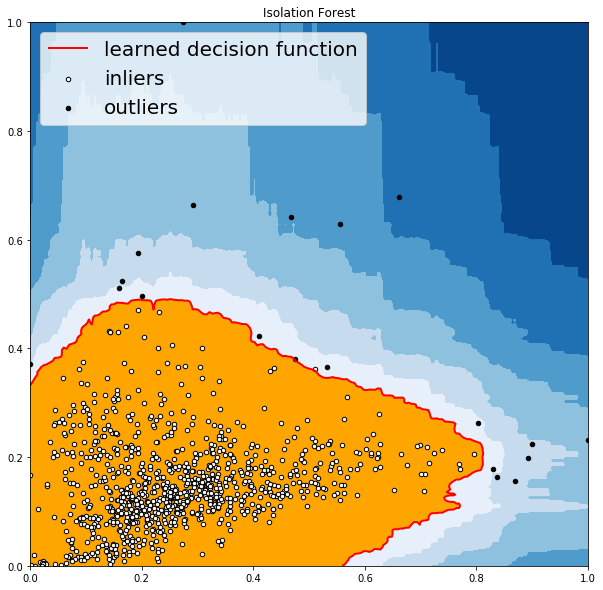

OUTLIERS :  15 INLIERS :  985 K Nearest Neighbors (KNN)


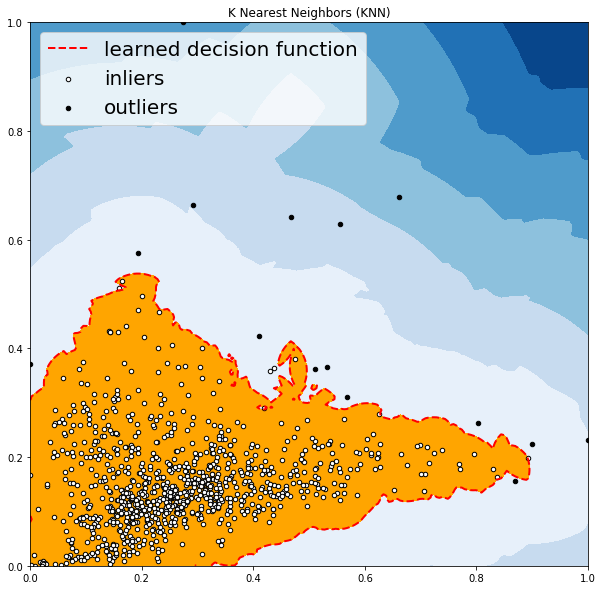

OUTLIERS :  11 INLIERS :  989 Average KNN


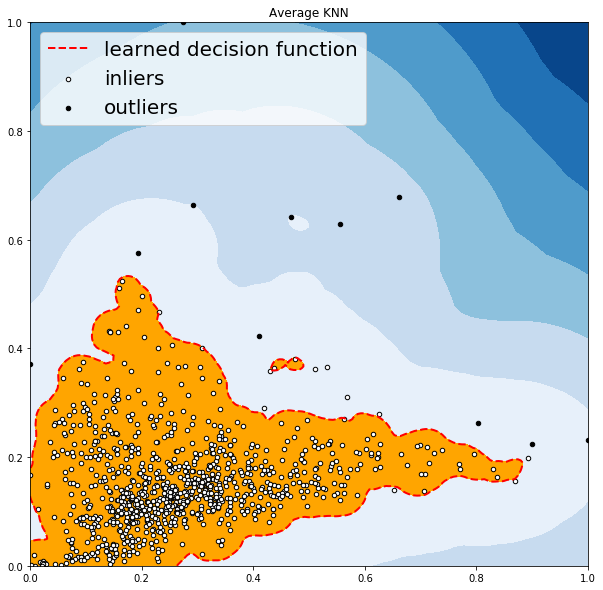

OUTLIERS :  18 INLIERS :  982 Local Outlier Factor (LOF)


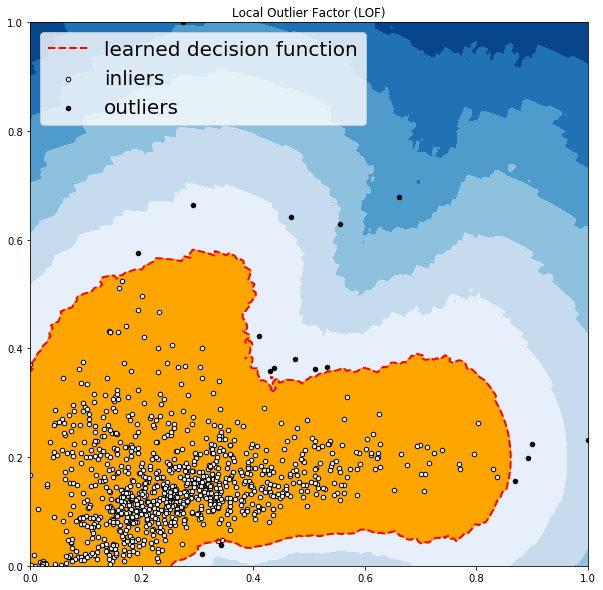

OUTLIERS :  20 INLIERS :  980 Minimum Covariance Determinant (MCD)


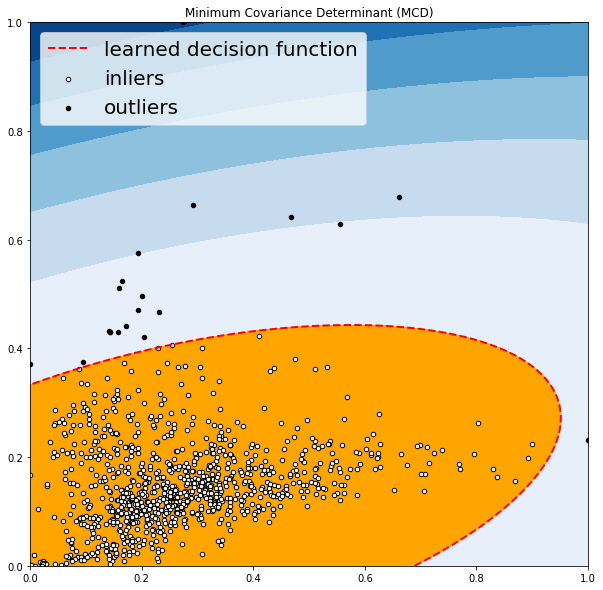

OUTLIERS :  20 INLIERS :  980 One-class SVM (OCSVM)


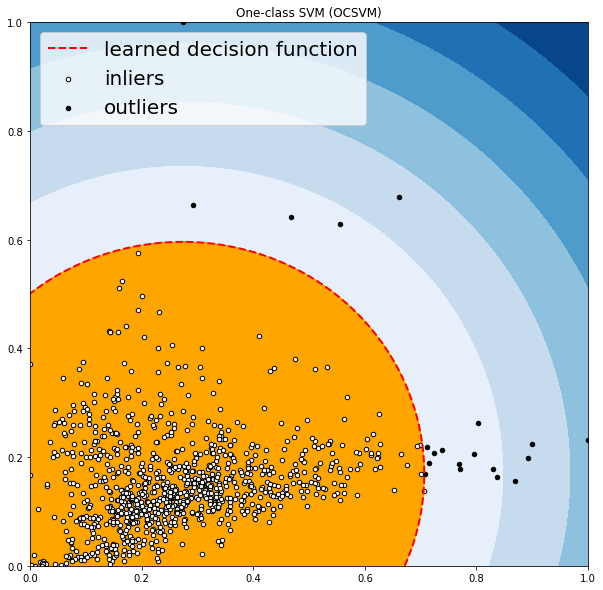

OUTLIERS :  20 INLIERS :  980 Principal Component Analysis (PCA)


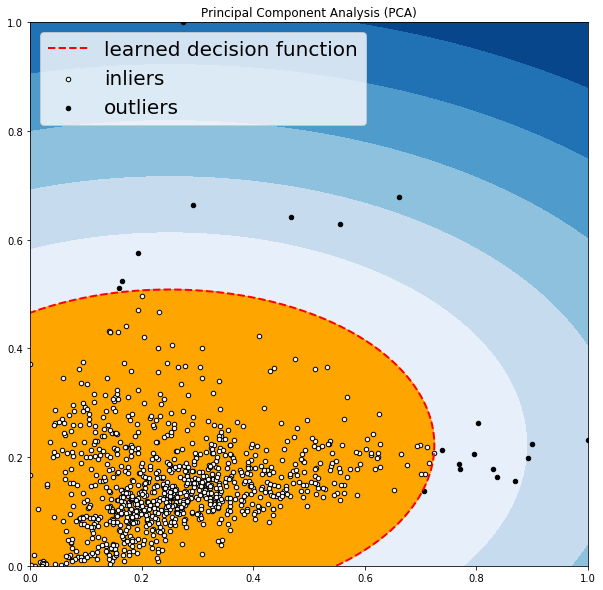

In [28]:
plot_outlier(df[0:1000], 'total_playhrs', 'unique_assets', 0.02) 

## compare clustering algorithms on total_play_hours and total_plays

OUTLIERS :  21 INLIERS :  979 Angle-based Outlier Detector (ABOD)


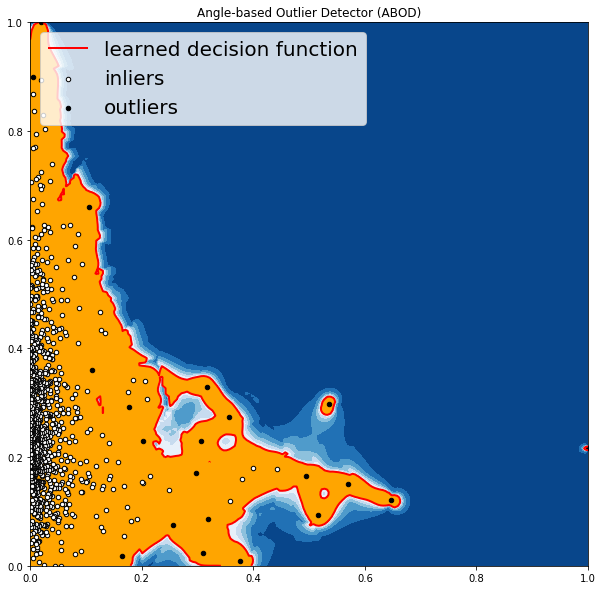

OUTLIERS :  20 INLIERS :  980 Cluster-based Local Outlier Factor (CBLOF)


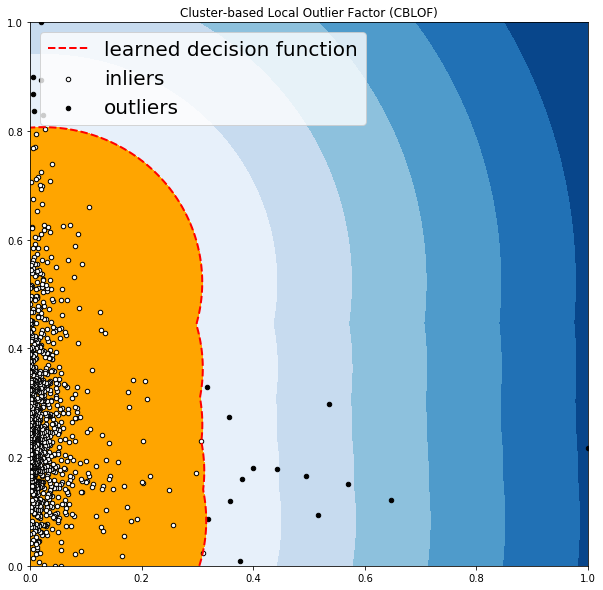

OUTLIERS :  19 INLIERS :  981 Histogram-base Outlier Detection (HBOS)


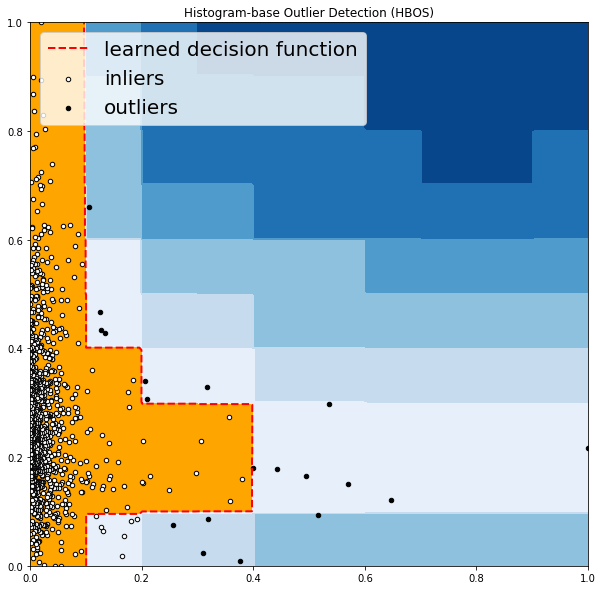

OUTLIERS :  20 INLIERS :  980 Isolation Forest


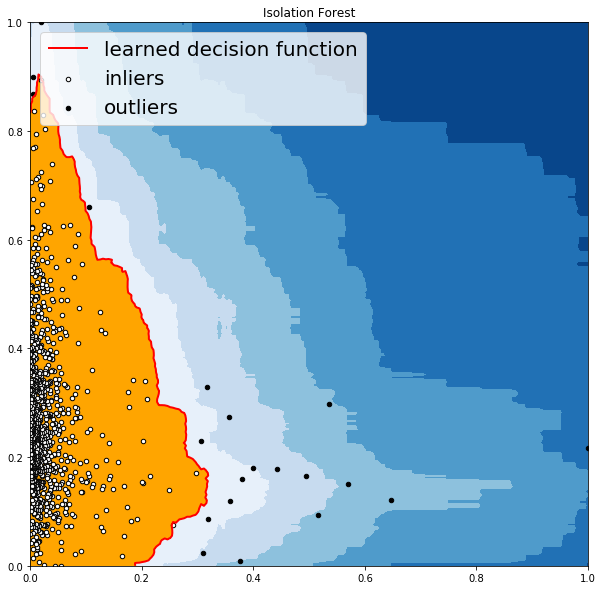

OUTLIERS :  15 INLIERS :  985 K Nearest Neighbors (KNN)


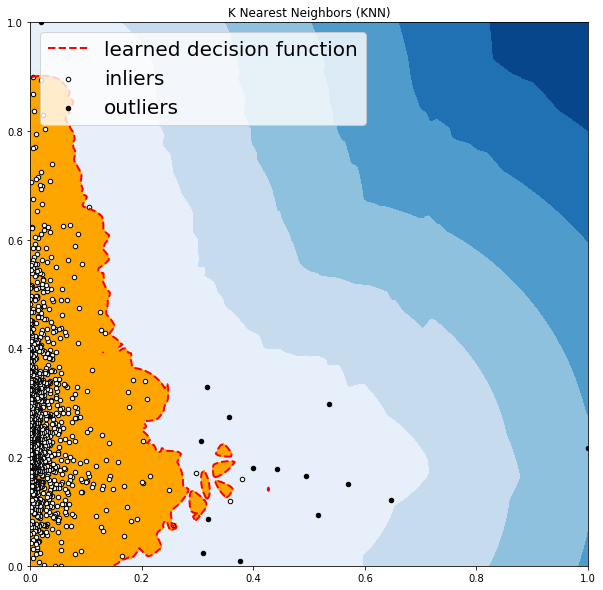

OUTLIERS :  10 INLIERS :  990 Average KNN


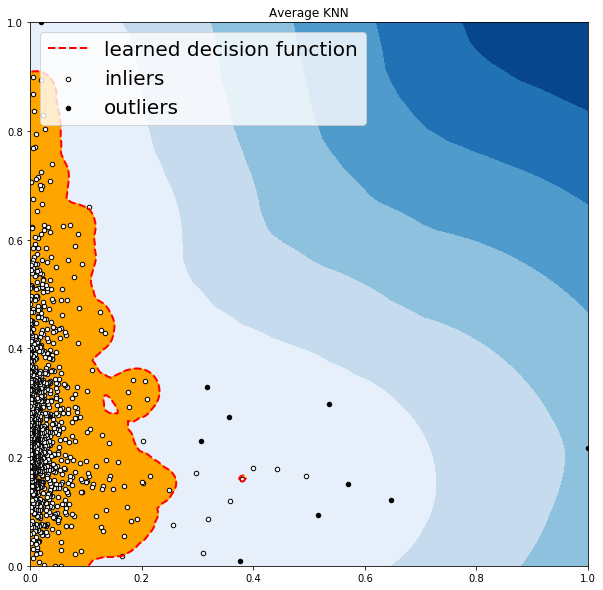

OUTLIERS :  18 INLIERS :  982 Local Outlier Factor (LOF)


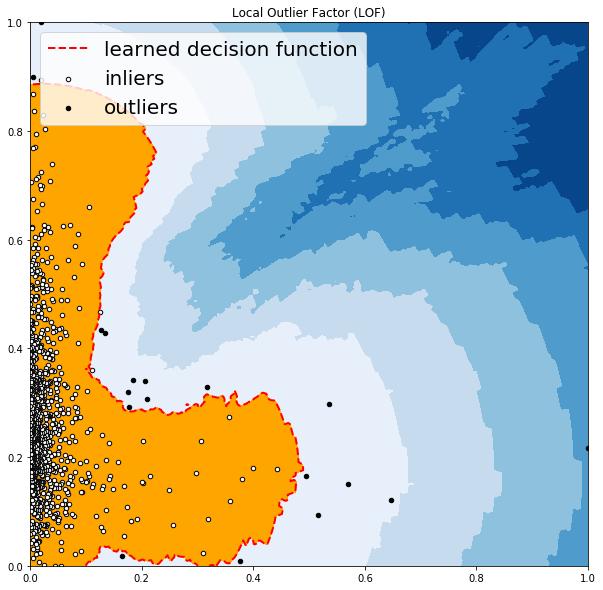

OUTLIERS :  20 INLIERS :  980 Minimum Covariance Determinant (MCD)


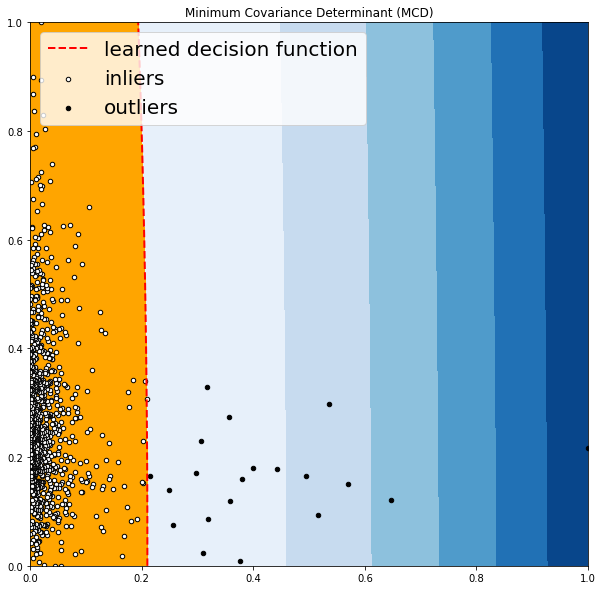

OUTLIERS :  20 INLIERS :  980 One-class SVM (OCSVM)


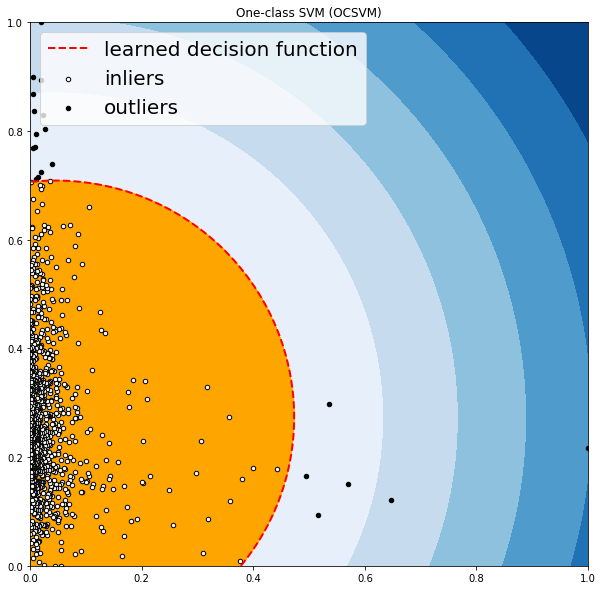

OUTLIERS :  20 INLIERS :  980 Principal Component Analysis (PCA)


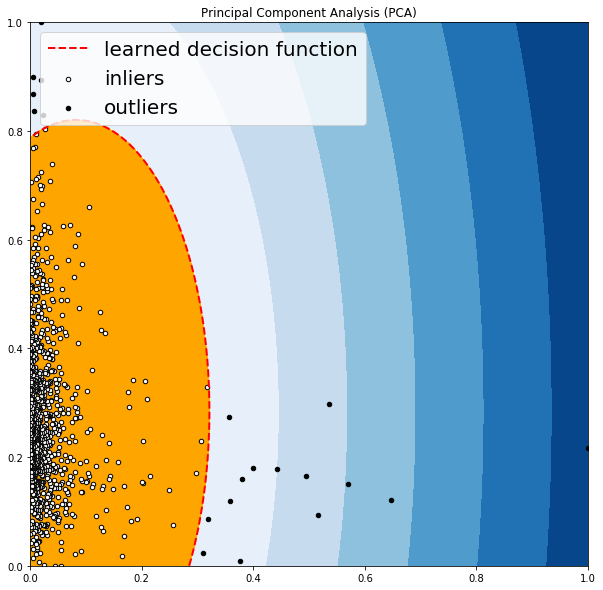

In [27]:
plot_outlier(df[0:1000], 'total_plays', 'total_playhrs', 0.02) 

## compare clustering algorithms on unique_assets and total_plays

OUTLIERS :  28 INLIERS :  972 Angle-based Outlier Detector (ABOD)


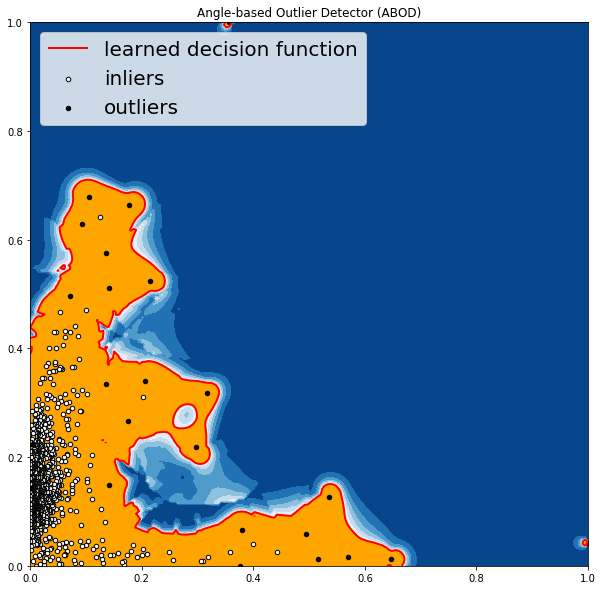

OUTLIERS :  20 INLIERS :  980 Cluster-based Local Outlier Factor (CBLOF)


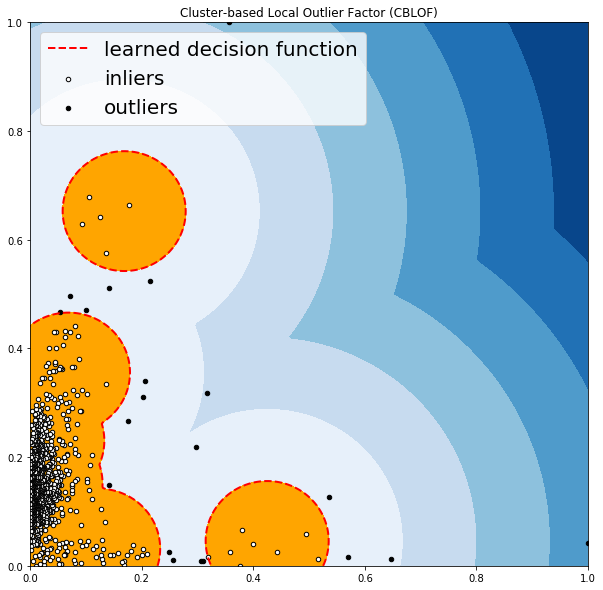

OUTLIERS :  20 INLIERS :  980 Histogram-base Outlier Detection (HBOS)


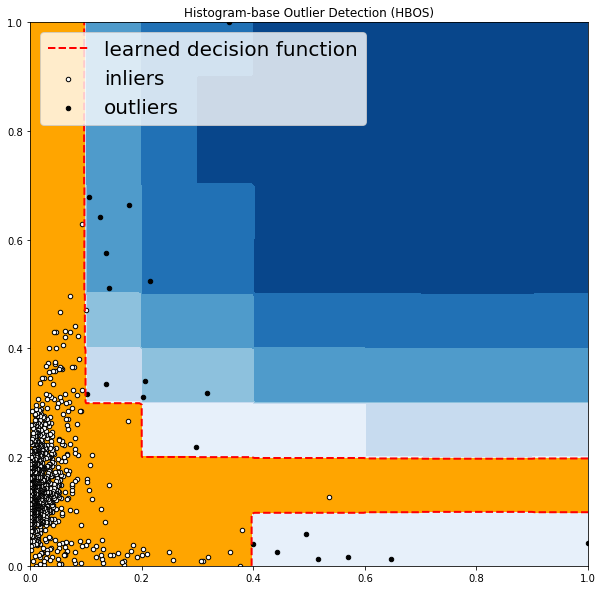

OUTLIERS :  20 INLIERS :  980 Isolation Forest


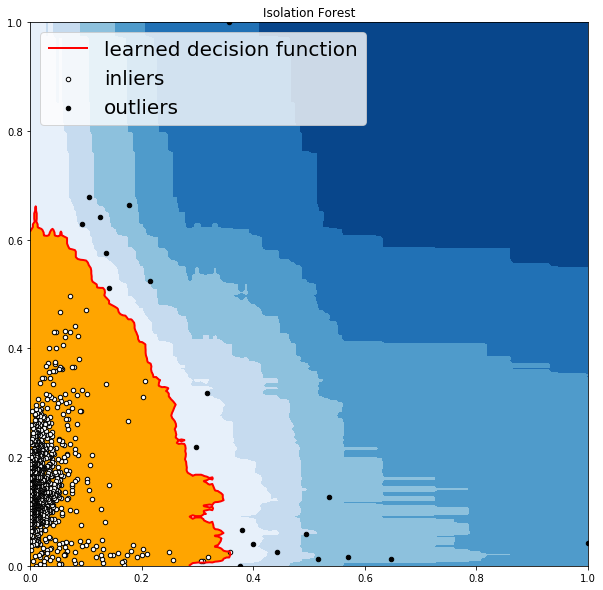

OUTLIERS :  17 INLIERS :  983 K Nearest Neighbors (KNN)


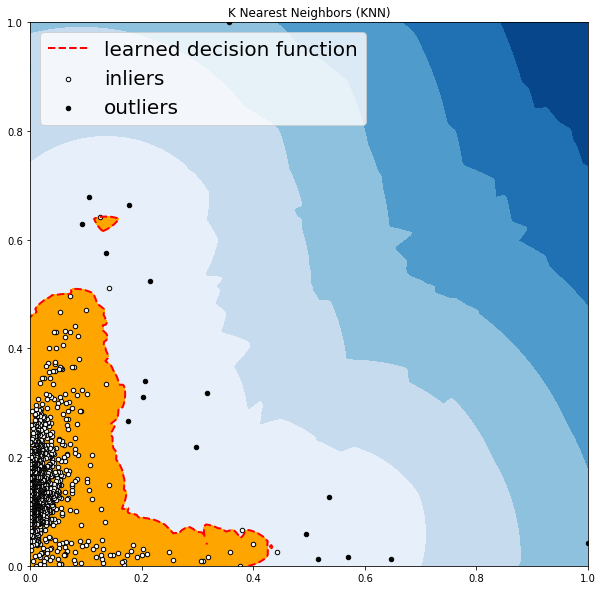

OUTLIERS :  9 INLIERS :  991 Average KNN


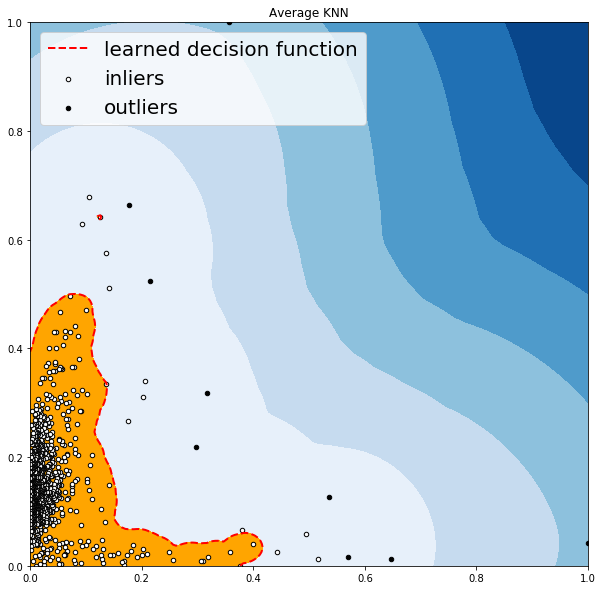

OUTLIERS :  20 INLIERS :  980 Local Outlier Factor (LOF)


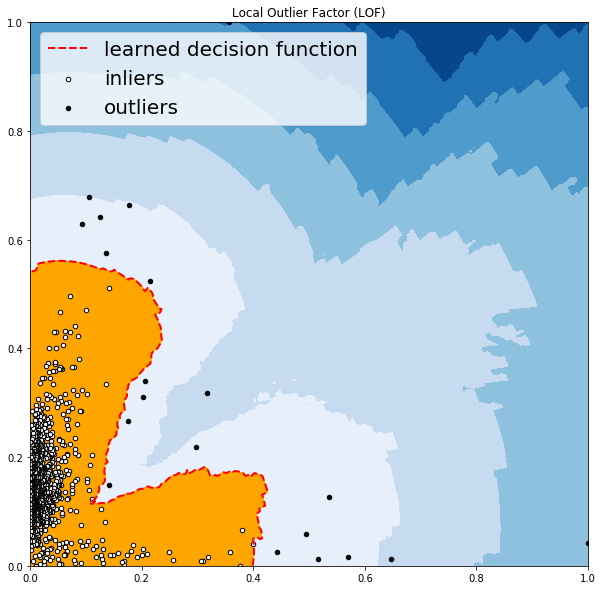

OUTLIERS :  20 INLIERS :  980 Minimum Covariance Determinant (MCD)


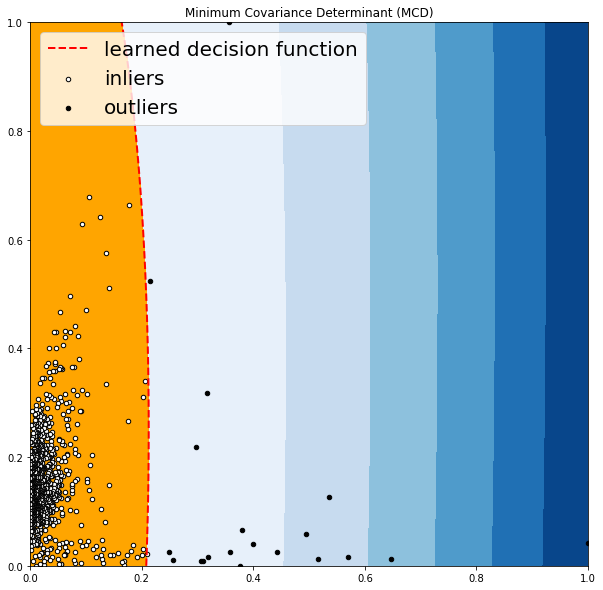

OUTLIERS :  20 INLIERS :  980 One-class SVM (OCSVM)


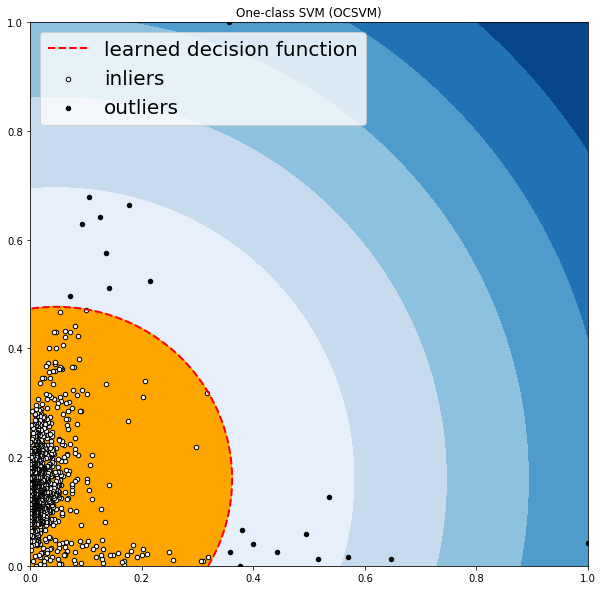

OUTLIERS :  20 INLIERS :  980 Principal Component Analysis (PCA)


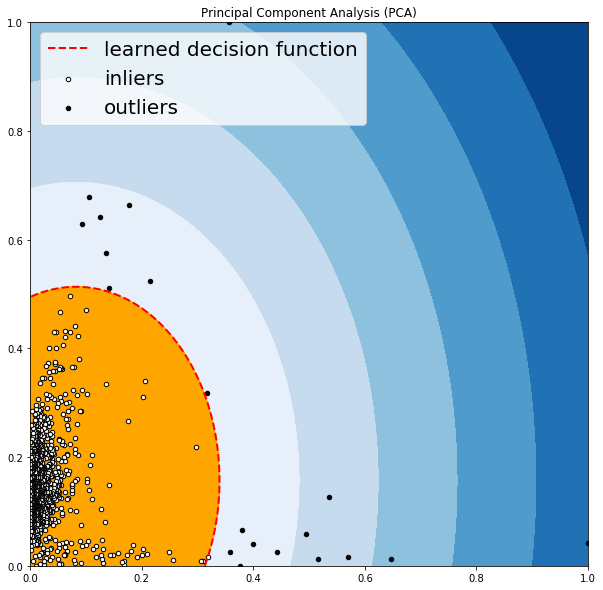

In [26]:
plot_outlier(df[0:1000], 'total_plays', 'unique_assets', 0.02) 

# Future works

* 3-dimensional clustering
* semi- / supervised learning method